# Decoding Fitzgerald
### _Exploring Themes and Emotions in F. Scott Fitzgerald’s Works with NLP_
**Author:** Virginia Herrero

## Import Libraries

In [1]:
# Utilities
import os
import re
import requests
import time
import csv
import numpy as np
from tqdm import tqdm

# Text processing
import nltk
from nltk.tokenize import sent_tokenize
from nltk.sentiment import SentimentIntensityAnalyzer

# Download NLTK resources
nltk.download('punkt')
nltk.download('vader_lexicon')

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Transformer
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch

[nltk_data] Downloading package punkt to C:\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package vader_lexicon to C:\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
c:\Users\Virginia\Python\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Data Collection

This project analyzes themes and emotions in F. Scott Fitzgerald's works using natural language processing techniques. The texts were sourced from Project Gutenberg, where only the first three novels—This Side of Paradise, The Beautiful and Damned, and The Great Gatsby—are available for free. Tender Is the Night is not yet in the public domain and therefore excluded from the analysis. Fitzgerald’s unfinished final novel, The Last Tycoon, published posthumously, is also not included.

In [2]:
# Ensure the raw data directory exists
os.makedirs("../data/raw", exist_ok = True)

# Dictionary of Fitzgerald's books and their Project Gutenberg plain text URLs
books = {
    "This-side-of-paradise": "https://www.gutenberg.org/cache/epub/805/pg805.txt",
    "The-beautiful-and-damned": "https://www.gutenberg.org/cache/epub/9830/pg9830.txt",
    "The-great-gatsby": "https://www.gutenberg.org/cache/epub/64317/pg64317.txt"   
}

# Download and save each book in the raw data directory
for title, url in books.items():
    print(f"Downloading {title}...")
    response = requests.get(url)
    if response.status_code == 200:
        filepath = f"../data/raw/{title}.txt"
        with open(filepath, "w", encoding = "utf-8") as f:
            f.write(response.text)
        print(f"Saved to {filepath}\n")
    else:
        print(f"Failed to download {title} from {url}\n")
    time.sleep(2)

print("All downloads completed!")

Saved to ../data/raw/This-side-of-paradise.txt

Saved to ../data/raw/The-beautiful-and-damned.txt

Saved to ../data/raw/The-great-gatsby.txt

All downloads completed!


## Data Cleaning

The raw texts from Project Gutenberg contain metadata, headers, footers, and other content that introduce noise into the analysis. To prepare the data for processing, a set of helper functions is used to clean and structure the text:

- `detect_narrative_start`: Finds where the actual story begins by matching characteristic first lines, allowing the script to skip over prefaces and metadata.
- `remove_appendix`: Removes the appendix section from *This Side of Paradise* based on a known heading.
- `normalize_chapter_headings`: Standardizes chapter formatting across all books by converting chapter numbers to Roman numerals where needed.
- `move_chapter_titles_to_new_line`: Ensures chapter headings appear on their own lines, even when embedded mid-paragraph.
- `clean_gutenberg_text_for_sentiment`: Cleans and normalizes punctuation, removes Gutenberg footer and appendix, and strips unwanted characters.
- `get_sentences`: Tokenizes the cleaned text into individual sentences using NLTK, preparing the data for sentiment and thematic analysis.

These modular functions make the pipeline easier to maintain and understand.

In [3]:
# Helper: find the actual start of narrative
def detect_narrative_start(text):
    """
    Detects the start of the main narrative in the text by matching known 
    opening lines from each book. This helps remove introductory material 
    like title pages or prefaces.

    Parameters:
    ----------
        text (str): The full raw text of the book.

    Returns:
    ----------
        str: The text starting from the detected beginning of the narrative.
    """
    patterns = [
        r'^\s*Amory Blaine inherited',                             # First line of This Side of Paradise
        r'^\s*In 1913, when Anthony Patch was twenty[- ]?five',    # First line of The Beautiful and Damned
        r'^\s*In my younger and more vulnerable years'             # First line of The Great Gatsby        
    ]

    for pattern in patterns:
        match = re.search(pattern, text, re.IGNORECASE | re.MULTILINE)
        if match:
            return text[match.start():]
        
    return text

In [4]:
# Helper: remove appendix from "This Side of Paradise"
def remove_appendix(text):
    """
    Removes the appendix from 'This Side of Paradise' starting from the 
    known appendix heading to the end of the text. This prevents non-narrative 
    metadata from polluting downstream analysis.

    Parameters:
    ----------
        text (str): The cleaned book text that may include an appendix.

    Returns:
    ----------
        str: The text with the appendix removed.
    """
    pattern = re.compile(r'\n\s*Appendix: Production notes for eBook edition 11.*', re.DOTALL | re.IGNORECASE)
    cleaned_text = re.sub(pattern, '', text)
    return cleaned_text.strip()


In [5]:
def normalize_chapter_headings(text, title):
    """
    Standardizes chapter headings across different books by:
    
    - Adding "CHAPTER I" to the beginning of the text.
    - Converting Arabic chapter numbers (e.g., "CHAPTER 1") to Roman numerals 
      for "This Side of Paradise", assuming chapters 1–5 only.
    - Replacing inline Roman numerals with "CHAPTER <numeral>" in "The Great Gatsby"
      when they appear before a capitalized word (e.g., chapter titles).
    
    Parameters:
    ----------
        text (str): The raw or cleaned book text.
        title (str): The title key of the book used to apply title-specific rules.
    
    Returns:
    ----------
        str: The text with normalized chapter headings.
    """
    text = "CHAPTER I\n" + text

    if title == "This-side-of-paradise":
        # Map Arabic numbers 1-5 to Roman numerals
        number_map = {
            '1': 'I',
            '2': 'II',
            '3': 'III',
            '4': 'IV',
            '5': 'V'
        }

        def repl(match):
            num = match.group(1)
            roman = number_map.get(num, num)  # fallback just in case
            return f"CHAPTER {roman}"

        # Replace 'CHAPTER <number>' with 'CHAPTER <Roman>'
        text = re.sub(r'CHAPTER (\d+)', repl, text)

    if title == "The-great-gatsby":
        roman_numerals = ["X", "IX", "VIII", "VII", "VI", "V", "IV", "III", "II", "I"]
        for numeral in roman_numerals:
            pattern = rf'(?<= )({numeral})(?= [A-Z])'
            text = re.sub(pattern, f'CHAPTER {numeral}', text)

    return text

In [6]:
def move_chapter_titles_to_new_line(text):
    """
    Ensures that chapter titles (e.g., "CHAPTER I", "CHAPTER 1") start on a new line,
    even if they appear in the middle of a paragraph or sentence.

    Matches both Roman numerals and Arabic digits following the word "CHAPTER".

    Parameters:
    ----------
        text (str): The input text containing chapter headings.

    Returns:
    -------
        str: Modified text where all chapter titles begin on their own line.
    """
    pattern = r'(?<!\n)(?<!^)(\bCHAPTER\s+(?:[IVXLCM]+|\d+)\b)'
    return re.sub(pattern, r'\n\1', text, flags=re.IGNORECASE)


In [7]:
# Helper: clean and prepare text
def clean_gutenberg_text_for_sentiment(text, title=""):
    """
    Cleans and prepares a Project Gutenberg text for NLP by:
    - Normalizing punctuation
    - Removing Gutenberg footer and appendix (if applicable)
    - Stripping headers and unwanted symbols
    - Detecting and starting from the narrative beginning

    Parameters:
    ----------
        text (str): The raw text of the book.
        title (str): The title of the book (used to apply title-specific rules).

    Returns:
    ----------
        str: Cleaned and normalized text ready for tokenization.
    """
    # Normalize punctuation
    text = text.replace("“", '"').replace("”", '"') \
               .replace("’", "'").replace("‘", "'").replace("—", "-")
    
    # Find narrative start
    text = detect_narrative_start(text)

    # Remove footer
    end_pattern = r'\*\*\* END OF.*?\*\*\*'
    parts = re.split(end_pattern, text, flags=re.IGNORECASE)
    if len(parts) > 1:
        text = parts[0]

    # Remove appendix if it's This Side of Paradise
    if "this-side-of-paradise" in title.lower():
        text = remove_appendix(text)

    # Normalize spaces and remove unwanted characters
    text = re.sub(r'\s+', ' ', text)
    text = re.sub(r'[^A-Za-z0-9.,!?\'"\s]', '', text)

    # Normalize chapter headers and fix formatting
    text = normalize_chapter_headings(text, title)
    text = move_chapter_titles_to_new_line(text)

    return text.strip()

In [8]:
def get_sentences(text):
    """
    Splits the input text into individual sentences using NLTK's sentence tokenizer.

    Parameters:
    ----------
        text (str): A cleaned string of text.

    Returns:
    ----------
        list: A list of sentence strings.
    """
    return sent_tokenize(text)

Once the helper functions are in place, the preprocessing pipeline follows these steps:

- Load each raw text file,
- Clean the content using the defined helper functions,
- Tokenize the cleaned text into individual sentences,
- Save the resulting sentences to new files in the `data/processed` directory,
- And print the first and last five sentences to visually verify the results.

This process ensures that the texts are properly structured and ready for downstream NLP tasks such as sentiment analysis and topic modeling.

In [9]:
print("== Cleaned Book Summary ==")
for title in books: 

    os.makedirs("../data/processed", exist_ok = True)
    raw_path = f"../data/raw/{title}.txt"
    clean_path = f"../data/processed/{title}-cleaned.txt"

    # Load raw text
    with open(raw_path, "r", encoding="utf-8") as f:
        raw_text = f.read()

    # Clean and tokenize
    cleaned_text = clean_gutenberg_text_for_sentiment(raw_text, title=title)
    sentences = get_sentences(cleaned_text)

    # Save cleaned sentences
    with open(clean_path, "w", encoding="utf-8") as f:
        f.writelines(sentence + "\n" for sentence in sentences)

    # Output summary
    print(f"\nTitle: '{title.replace('-', ' ').title()}'")
    print(f"Saved: {len(sentences):,} sentences")
    print(f"File path: {clean_path}")

    print("\nFirst 5 sentences:\n")
    for i, sent in enumerate(sentences[:5], 1):
        print(f"  {i}. {sent}")

    print("\nLast 5 sentences:\n")
    for i, sent in enumerate(sentences[-5:], len(sentences) - 4):
        print(f"  {i}. {sent}")

    print("-" * 60)

== Cleaned Book Summary ==

Title: 'This Side Of Paradise'
Saved: 5,411 sentences
File path: ../data/processed/This-side-of-paradise-cleaned.txt

First 5 sentences:

  1. CHAPTER I
Amory Blaine inherited from his mother every trait, except the stray inexpressible few, that made him worth while.
  2. His father, an ineffectual, inarticulate man with a taste for Byron and a habit of drowsing over the Encyclopedia Britannica, grew wealthy at thirty through the death of two elder brothers, successful Chicago brokers, and in the first flush of feeling that the world was his, went to Bar Harbor and met Beatrice O'Hara.
  3. In consequence, Stephen Blaine handed down to posterity his height of just under six feet and his tendency to waver at crucial moments, these two abstractions appearing in his son Amory.
  4. For many years he hovered in the background of his family's life, an unassertive figure with a face halfobliterated by lifeless, silky hair, continually occupied in "taking care" of 

## Sentiment Analysis

Sentiment analysis is the process of determining whether a text expresses a positive, neutral or negative emotion.

### **VADER** 

In this part of the project, each sentences from the cleaned texts is analyzed using VADER, a tool from NLTK designed to detect tone in everyday English. VADER assigns scores for each of these categories along with an overall sentiment for every sentence. The results are save for each book and used to calculate average sentiment, giving a sense of the emotional tone along  the novels. This helps beginning to explor how the mood shifts within and between Fitzgerald's works. 

In [10]:
# Initialize VADER sentiment analyzer
sia = SentimentIntensityAnalyzer()

# Create output directory if it doesn't exist
os.makedirs("../results/sentiment-analysis/vader", exist_ok = True)

print("== Sentiment Analysis: VADER ==")

for title in books:
    clean_path = f"../data/processed/{title}-cleaned.txt"

    if not os.path.exists(clean_path):
        print(f"File not found: {clean_path}")
        continue

    # Read cleaned sentences from file
    with open(clean_path, "r", encoding = "utf-8") as f:
        sentences = [line.strip() for line in f if line.strip()]

    sentiment_data = []
    for sentence in sentences:
        scores = sia.polarity_scores(sentence)
        sentiment_data.append({
            "sentence": sentence,
            "neg": scores["neg"],
            "neu": scores["neu"],
            "pos": scores["pos"],
            "compound": scores["compound"]
        })

    # Save sentiment results to CSV
    output_path = f"../results/sentiment-analysis/vader/{title}-sentiment-analysis-vader.csv"
    with open(output_path, "w", encoding = "utf-8", newline = "") as f:
        writer = csv.DictWriter(f, fieldnames=["sentence", "neg", "neu", "pos", "compound"])
        writer.writeheader()
        writer.writerows(sentiment_data)

    # Calculate average compound score
    avg_score = sum(d["compound"] for d in sentiment_data) / len(sentiment_data) if sentiment_data else 0

    # Determine overall sentiment label
    if avg_score > 0.05:
        label = "Positive"
    elif avg_score < -0.05:
        label = "Negative"
    else:
        label = "Neutral"

    # Output summary
    print(f"\nTitle: {title.replace('-', ' ').title()}")
    print(f"Average Sentiment Score: {avg_score:.2f}")
    print(f"Overall Sentiment Label: {label}")
    print("-" * 60)

== Sentiment Analysis: VADER ==

Title: This Side Of Paradise
Average Sentiment Score: 0.06
Overall Sentiment Label: Positive
------------------------------------------------------------

Title: The Beautiful And Damned
Average Sentiment Score: 0.04
Overall Sentiment Label: Neutral
------------------------------------------------------------

Title: The Great Gatsby
Average Sentiment Score: 0.03
Overall Sentiment Label: Neutral
------------------------------------------------------------


The sentiment analysis shows that all three novels have a slightly positive overall tone. *This Side of Paradise* comes across as a bit more upbeat compared to the other two, which lean closer to neutral. That fits with its youthful and hopeful vibe, while *The Beautiful and Damned* and *The Great Gatsby* feel a bit more calm emotionally.

It’s worth keeping in mind that this kind of sentence-level, lexicon-based analysis can miss some of the complexity, like irony or deeper context. Still, it gives a good general sense of the emotional mood in each book.

A closer look at sentiment on a chapter-by-chapter basis could be a great next step to see how the emotions change and develop throughout each story.

In [11]:
def split_into_chapters(text):
    """
    Splits a full text into chapters based on common chapter headings.

    Recognizes patterns like "Chapter 1", "Chapter I", "Chapter One", etc.

    Parameters:
    ----------
        text (str): The full raw text of a book or document.

    Returns:
    ----------
        List[Tuple[str, str]]: A list of tuples, each containing:
            - chapter title (e.g., 'Chapter 1')
            - chapter text (stripped of leading/trailing whitespace)
    """
    chapter_pattern = re.compile(r'(?:^|\n)(chapter [ivxlc\d]+|chapter \w+)', re.IGNORECASE)
    splits = chapter_pattern.split(text)
    chapters = []
    for i in range(1, len(splits), 2):
        chapter_title = splits[i].strip()
        chapter_text = splits[i+1] if i+1 < len(splits) else ''
        chapters.append((chapter_title, chapter_text.strip()))
    return chapters


def chapter_sentiment(chapters):
    """
    Performs sentiment analysis on each chapter based on sentence-level compound scores.

    Aggregates sentence-level sentiment scores into an average score for the chapter
    and assigns an overall sentiment label.

    Parameters:
    ----------
        chapters (List[Tuple[str, str]]): List of (chapter_title, chapter_text) pairs.

    Returns:
    ----------
        List[Dict]: A list of dictionaries for each chapter containing:
            - 'chapter': title of the chapter
            - 'avg_compound': average compound sentiment score
            - 'num_sentences': number of sentences in the chapter
            - 'sentiment_label': overall sentiment label ('Positive', 'Negative', 'Neutral')
    """
    chapter_scores = []
    for title, text in chapters:
        sentences = sent_tokenize(text)
        scores = [sia.polarity_scores(s)['compound'] for s in sentences if s.strip()]
        avg_score = sum(scores) / len(scores) if scores else 0

        if avg_score > 0.05:
            label = "Positive"
        elif avg_score < -0.05:
            label = "Negative"
        else:
            label = "Neutral"

        chapter_scores.append({
            "chapter": title,
            "avg_compound": avg_score,
            "num_sentences": len(sentences),
            "sentiment_label": label
        })
    return chapter_scores

In [12]:
os.makedirs("../results/sentiment-analysis/vader", exist_ok = True)

print("== Sentiment Analysis Per Chapter: VADER ==")

for title in books:
    clean_path = f"../data/processed/{title}-cleaned.txt"

    if not os.path.exists(clean_path):
        print(f"File not found: {clean_path}")
        continue

    with open(clean_path, "r", encoding="utf-8") as f:
        text = f.read()

    chapters = split_into_chapters(text)
    chapter_scores = chapter_sentiment(chapters)
    
    # Save results
    output_path = f"../results/sentiment-analysis/vader/{title}-sentiment-analysis-per-chapter-vader.csv"
    with open(output_path, "w", encoding = "utf-8", newline = "") as f:
        writer = csv.DictWriter(f, fieldnames=["chapter", "avg_compound", "num_sentences", "sentiment_label"])
        writer.writeheader()
        writer.writerows(chapter_scores)

    # Output summary
    print(f"\nTitle: {title.replace('-', ' ').title()}\n")
    for ch in chapter_scores:
        print(f"{ch['chapter']:<12}: Average Compound Sentiment: {ch['avg_compound']:.2f} — {ch['sentiment_label']}")
    print("-" * 60)

== Sentiment Analysis Per Chapter: VADER ==

Title: This Side Of Paradise

CHAPTER I   : Average Compound Sentiment: 0.11 — Positive
CHAPTER II  : Average Compound Sentiment: 0.09 — Positive
CHAPTER III : Average Compound Sentiment: 0.01 — Neutral
CHAPTER IV  : Average Compound Sentiment: 0.05 — Positive
CHAPTER I   : Average Compound Sentiment: 0.10 — Positive
CHAPTER II  : Average Compound Sentiment: 0.04 — Neutral
CHAPTER III : Average Compound Sentiment: 0.05 — Positive
CHAPTER IV  : Average Compound Sentiment: -0.02 — Neutral
CHAPTER V   : Average Compound Sentiment: 0.01 — Neutral
------------------------------------------------------------

Title: The Beautiful And Damned

CHAPTER I   : Average Compound Sentiment: 0.13 — Positive
CHAPTER II  : Average Compound Sentiment: 0.09 — Positive
CHAPTER III : Average Compound Sentiment: 0.06 — Positive
CHAPTER I   : Average Compound Sentiment: 0.05 — Neutral
CHAPTER II  : Average Compound Sentiment: 0.02 — Neutral
CHAPTER III : Average C

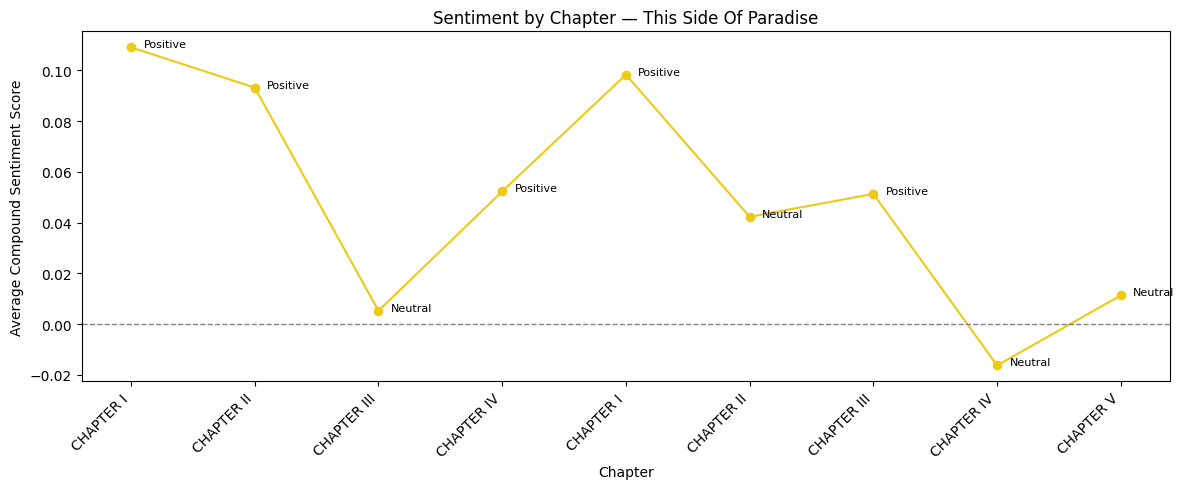

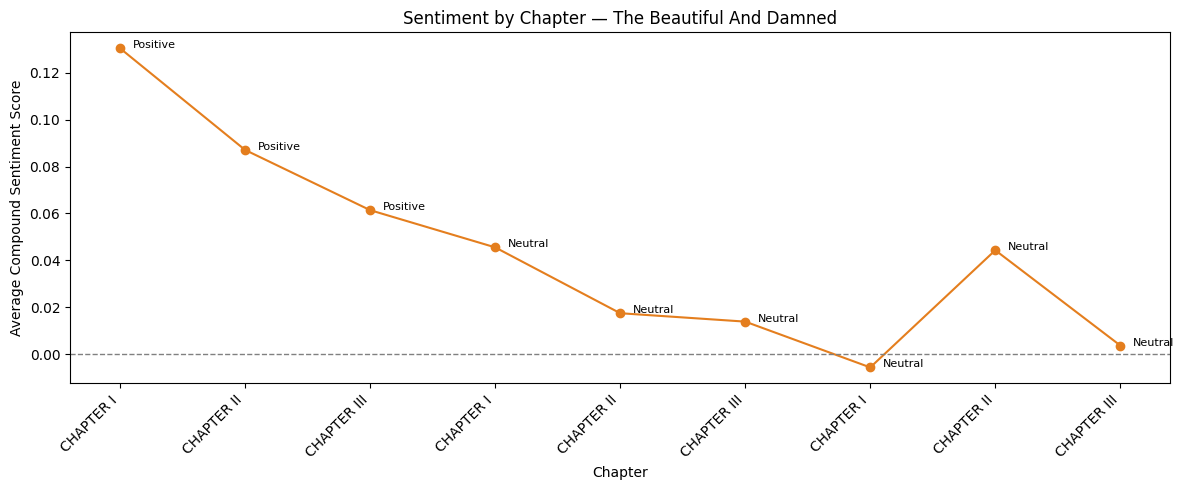

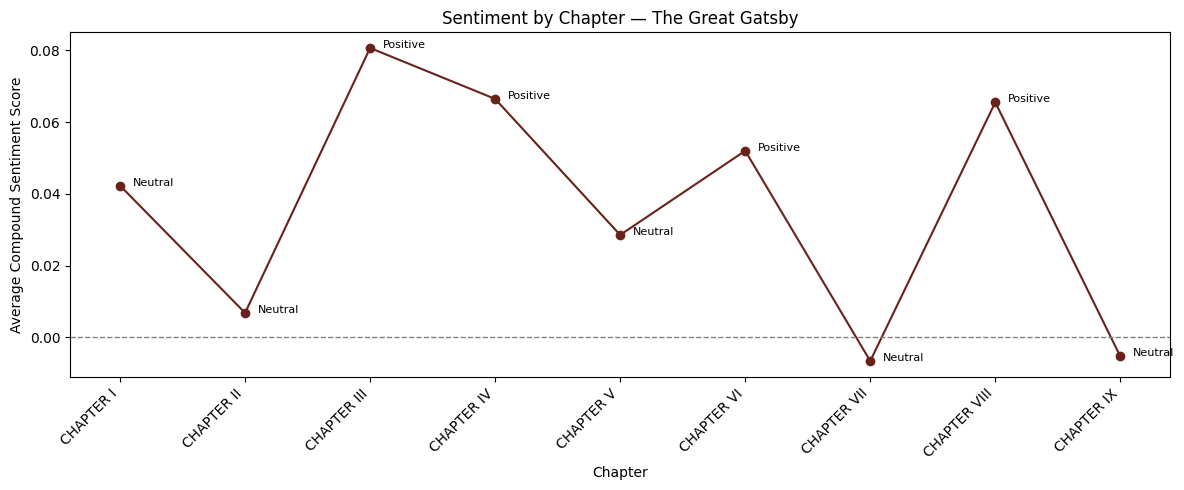

In [13]:
# Create output directory
os.makedirs("../figures/sentiment-analysis", exist_ok = True)

colors = ["#eeca16", "#e47e1e", "#6a2119"]

for title, color in zip(books, colors):
    csv_path = f"../results/sentiment-analysis/vader/{title}-sentiment-analysis-per-chapter-vader.csv"
    
    if not os.path.exists(csv_path):
        print(f"Missing sentiment file for {title}")
        continue

    chapters = []
    scores = []
    labels = []

    # Load CSV data
    with open(csv_path, "r", encoding = "utf-8") as f:
        reader = csv.DictReader(f)
        for row in reader:
            chapters.append(row["chapter"])
            scores.append(float(row["avg_compound"]))
            labels.append(row["sentiment_label"])

    # Clean book title
    pretty_title = title.replace("-", " ").title()

    # Plot
    plt.figure(figsize = (12, 5))
    plt.plot(scores, marker = "o", color = color)

    for i, label in enumerate(labels):
        plt.text(i + 0.1, scores[i], label, fontsize = 8)

    plt.axhline(0, color = "gray", linestyle = "--", linewidth = 1)
    plt.xticks(ticks=range(len(chapters)), labels = chapters, rotation = 45, ha = "right")
    plt.title(f"Sentiment by Chapter — {pretty_title}")
    plt.xlabel("Chapter")
    plt.ylabel("Average Compound Sentiment Score")
    plt.tight_layout()
    plt.savefig(f"../figures/sentiment-analysis/{title}-sentiment-analysis-by-chapter.png")

Looking at the sentiment by chapter, *This Side of Paradise* generally stays on the positive side, especially in the beginning, though some chapters later on are more neutral. *The Beautiful and Damned* starts off positive but then mostly stays neutral. *The Great Gatsby* goes back and forth between neutral and a little positive, with a few chapters dropping back to neutral. Overall, the feelings in the books switch between a bit of positivity and neutral, matching how the stories go up and down.

### **Cardiff RoBERTa**

In this next chapter, the analysis of Fitzgerald’s works will shift from the basic VADER tool to the more advanced **Cardiff RoBERTa** model. While VADER is a straightforward and easy to use lexicon-based approach, it often struggles with capturing the deeper nuances and complexities of literary language. Cardiff RoBERTa, on the other hand, is a transformer-based model that’s been fine-tuned specifically for sentiment analysis. It understands context much better and can pick up on subtle emotional cues that simpler methods might miss. Using this model will provide a more nuanced and accurate look at the sentiment throughout Fitzgerald’s novels, helping to uncover layers of meaning beyond just positive or negative tones.

#### Sentiment Scoring for Comparison

To compare the outputs of VADER and Cardiff RoBERTa more directly, a simple scoring system was applied to the RoBERTa predictions. Since VADER provides both a continuous sentiment score (ranging from -1 to 1) and a corresponding label, a similar numeric representation was created for the RoBERTa results.

Each sentence predicted by RoBERTa was assigned a score based on its predicted label:

* **Positive** → +1
* **Neutral** → 0
* **Negative** → -1

The average sentiment score across all sentences in each novel was then calculated, and an overall sentiment label was assigned using the same thresholds applied in the VADER analysis:

* Score > 0.05 → **Positive**
* Score < -0.05 → **Negative**
* Otherwise → **Neutral**

While this method simplifies RoBERTa’s more nuanced probability-based output, it allows for a consistent comparison with VADER’s results in both format and interpretation. This approach helps highlight general trends in sentiment across the texts, while acknowledging that different models interpret language and context in different ways.

In [15]:
# Load the model and tokenizer
transformer_model_name = "cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(transformer_model_name)
transformer_model = AutoModelForSequenceClassification.from_pretrained(transformer_model_name)

# Class labels for this model
transformer_labels = ["Negative", "Neutral", "Positive"]

def transformer_sentiment(text):
    """
    Analyze the sentiment of a given text sentence using the Cardiff RoBERTa transformer model.
    
    Parameters: 
    ----------
        text (str): The sentence to analyze.
    
    Returns:
    ----------
        dict: A dictionary mapping sentiment labels ('Negative', 'Neutral', 'Positive') to their respective probability scores.
    """
    inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=512)
    with torch.no_grad():
        outputs = transformer_model(**inputs)
        probs = torch.nn.functional.softmax(outputs.logits, dim=1).squeeze().tolist()
    return dict(zip(transformer_labels, probs))


os.makedirs("../results/sentiment-analysis/transformer", exist_ok=True)

print("== Sentiment Analysis: Cardiff RoBERTa Transformer ==")
print("\nNOTE: The output of the transformer model has been mapped to match VADER's format")
print("      (using -1 for Negative, 0 for Neutral, +1 for Positive) for comparison purposes.")
print("      This mapping is a simplification and may not reflect the full nuance of the model.\n")


for title in books:
    clean_path = f"../data/processed/{title}-cleaned.txt"
    
    if not os.path.exists(clean_path):
        print(f"File not found: {clean_path}")
        continue

    # Load cleaned sentences
    with open(clean_path, "r", encoding="utf-8") as f:
        sentences = [line.strip() for line in f if line.strip()]

    results = []
    for sentence in sentences:
        scores = transformer_sentiment(sentence)
        results.append({
            "sentence": sentence,
            "negative": scores["Negative"],
            "neutral": scores["Neutral"],
            "positive": scores["Positive"],
            "predicted_label": max(scores, key=scores.get)
        })

    output_path = f"../results/sentiment-analysis/transformer/{title}-sentiment-analysis-transformer.csv"
    with open(output_path, "w", encoding="utf-8", newline="") as f:
        writer = csv.DictWriter(f, fieldnames=["sentence", "negative", "neutral", "positive", "predicted_label"])
        writer.writeheader()
        writer.writerows(results)

    # VADER-style output summary
    """ Disclaimer:
    To compare transformer sentiment results with VADER, we map RoBERTa's predicted labels to numeric values: -1 for Negative, 0 for Neutral, +1 for Positive.
    This allows us to compute an average sentiment score similar to VADER's, but is a simplified approximation of the model’s more nuanced output.
    """

    score_map = {"Negative": -1, "Neutral": 0, "Positive": 1}
    total_score = 0
    label_counts = {"Negative": 0, "Neutral": 0, "Positive": 0}

    for r in results:
        label = r["predicted_label"]
        label_counts[label] += 1
        total_score += score_map[label]

    avg_score = total_score / len(results) if results else 0

    if avg_score > 0.05:
        overall_label = "Positive"
    elif avg_score < -0.05:
        overall_label = "Negative"
    else:
        overall_label = "Neutral"

    # Final formatted summary (matches VADER output)
    print(f"\nTitle: {title.replace('-', ' ').title()}")
    print(f"Average Sentiment Score: {avg_score:.2f}")
    print(f"Overall Sentiment Label: {overall_label}")
    print("-" * 60)

== Sentiment Analysis: Cardiff RoBERTa Transformer ==

NOTE: The output of the transformer model has been mapped to match VADER's format
      (using -1 for Negative, 0 for Neutral, +1 for Positive) for comparison purposes.
      This mapping is a simplification and may not reflect the full nuance of the model.


Title: This Side Of Paradise
Average Sentiment Score: -0.07
Overall Sentiment Label: Negative
------------------------------------------------------------

Title: The Beautiful And Damned
Average Sentiment Score: -0.07
Overall Sentiment Label: Negative
------------------------------------------------------------

Title: The Great Gatsby
Average Sentiment Score: -0.03
Overall Sentiment Label: Neutral
------------------------------------------------------------


As done with VADER, a sentiment analysis per chapter is done using Cardiff RoBERTa model. 

In [16]:
# Label mapping to VADER-style scoring
score_map = {"Negative": -1, "Neutral": 0, "Positive": 1}

def transformer_chapter_sentiment(chapters):
    """
    Perform sentiment analysis on each chapter using CardiffNLP RoBERTa,
    and output average sentiment score (mapped like VADER) per chapter.
    """
    chapter_scores = []

    for chapter_title, chapter_text in chapters:
        sentences = sent_tokenize(chapter_text)
        predictions = [transformer_sentiment(s) for s in sentences if s.strip()]

        # Get predicted label per sentence
        predicted_labels = [max(p, key=p.get) for p in predictions]

        total_score = sum(score_map[label] for label in predicted_labels)
        avg_score = total_score / len(predicted_labels) if predicted_labels else 0

        if avg_score > 0.05:
            sentiment_label = "Positive"
        elif avg_score < -0.05:
            sentiment_label = "Negative"
        else:
            sentiment_label = "Neutral"

        chapter_scores.append({
            "chapter": chapter_title,
            "avg_sentiment_score": avg_score,
            "num_sentences": len(predicted_labels),
            "sentiment_label": sentiment_label
        })

    return chapter_scores

In [17]:
os.makedirs("../results/sentiment-analysis/transformer", exist_ok=True)

print("== Sentiment Analysis per Chapter: Cardiff RoBERTa Transformer ==")
print("\nNOTE: RoBERTa labels mapped to VADER-style sentiment scores (-1, 0, +1)\n")

for title in books:
    clean_path = f"../data/processed/{title}-cleaned.txt"

    if not os.path.exists(clean_path):
        print(f"File not found: {clean_path}")
        continue

    with open(clean_path, "r", encoding="utf-8") as f:
        text = f.read()

    chapters = split_into_chapters(text)
    chapter_scores = transformer_chapter_sentiment(chapters)

    output_path = f"../results/sentiment-analysis/transformer/{title}-sentiment-analysis-chapters-transformer.csv"
    with open(output_path, "w", encoding="utf-8", newline="") as f:
        writer = csv.DictWriter(f, fieldnames=["chapter", "avg_sentiment_score", "num_sentences", "sentiment_label"])
        writer.writeheader()
        writer.writerows(chapter_scores)

    # Ouput summary
    print(f"\nTitle: {title.replace('-', ' ').title()}\n")
    for ch in chapter_scores:
        print(f"{ch['chapter']:<12}: Average Sentiment Score: {ch['avg_sentiment_score']:.2f} — {ch['sentiment_label']}")
    print("-" * 60)

== Sentiment Analysis per Chapter: Cardiff RoBERTa Transformer ==

NOTE: RoBERTa labels mapped to VADER-style sentiment scores (-1, 0, +1)


Title: This Side Of Paradise

CHAPTER I   : Average Sentiment Score: 0.02 — Neutral
CHAPTER II  : Average Sentiment Score: 0.01 — Neutral
CHAPTER III : Average Sentiment Score: -0.13 — Negative
CHAPTER IV  : Average Sentiment Score: -0.11 — Negative
CHAPTER I   : Average Sentiment Score: -0.04 — Neutral
CHAPTER II  : Average Sentiment Score: -0.13 — Negative
CHAPTER III : Average Sentiment Score: -0.06 — Negative
CHAPTER IV  : Average Sentiment Score: -0.10 — Negative
CHAPTER V   : Average Sentiment Score: -0.17 — Negative
------------------------------------------------------------

Title: The Beautiful And Damned

CHAPTER I   : Average Sentiment Score: 0.01 — Neutral
CHAPTER II  : Average Sentiment Score: 0.01 — Neutral
CHAPTER III : Average Sentiment Score: -0.03 — Neutral
CHAPTER I   : Average Sentiment Score: -0.08 — Negative
CHAPTER II  : Av

Across all three novels, Cardiff RoBERTa tends to lean slightly negative, especially as the stories progress.

In This Side of Paradise, the early chapters come across as mostly neutral, but sentiment steadily dips into negative territory, reflecting an emotional or narrative decline. Later chapters consistently score below zero, suggesting a shift toward darker or more introspective content.

The Beautiful and Damned shows a similar pattern. It starts out fairly neutral but becomes increasingly negative over time. By the second half of the book, almost every chapter is labeled negative, which aligns with the novel’s growing emotional weight and instability.

In The Great Gatsby, sentiment remains more balanced overall. Early and mid chapters are mostly neutral or slightly positive, with a mild downturn in the final chapters. While still less upbeat than VADER’s readings, RoBERTa captures a more subtle descent into melancholy by the novel’s end.

### **VADER vs Cardiff RoBERTa**

Now that the sentiment analysis is complete, it's it’s time to take a closer look at how VADER and Cardiff RoBERTa performed and how each model handles emotional tone across the texts.

#### **Model Overview**

| Model               | Strengths                                              | Weaknesses                                                    |
| ------------------- | ------------------------------------------------------ | ------------------------------------------------------------- |
| **VADER**           | Fast, rule-based, good for short social/text-like data | Misses context, sarcasm, deeper narrative tones               |
| **Cardiff RoBERTa** | Context-aware, better at literary/narrative nuance     | Slower, may be slightly more negative in tone across chapters |

#### **Sentence Sentiment Analysis Comparison**

| Title                    | VADER Avg | VADER Label | Cardiff RoBERTa Avg | Cardiff RoBERTa Label |
| ------------------------ | --------- | ----------- | ------------------- | --------------------- |
| This Side of Paradise    | **0.06**  | Positive    | **-0.07**           | Negative              |
| The Beautiful and Damned | **0.04**  | Neutral     | **-0.07**           | Negative              |
| The Great Gatsby         | **0.03**  | Neutral     | **-0.03**           | Neutral               |

**Observations:**

- VADER leans more positive overall.
- Cardiff RoBERTa is notably more **negative**, especially for the first two titles.

#### **Sentiment Analysis Per Chapter Comparison: This Side of Paradise**

| Chapter     | VADER Avg | VADER Label | Cardiff RoBERTa Avg | Cardiff RoBERTa Label |
| ----------- | --------- | ----------- | ------------------- | --------------------- |
| CHAPTER I   | 0.11      | Positive    | 0.02                | Neutral               |
| CHAPTER II  | 0.09      | Positive    | 0.01                | Neutral               |
| CHAPTER III | 0.01      | Neutral     | -0.13               | Negative              |
| CHAPTER IV  | 0.05      | Positive    | -0.11               | Negative              |
| CHAPTER I   | 0.10      | Positive    | -0.04               | Neutral               |
| CHAPTER II  | 0.04      | Neutral     | -0.13               | Negative              |
| CHAPTER III | 0.05      | Positive    | -0.06               | Negative              |
| CHAPTER IV  | -0.02     | Neutral     | -0.10               | Negative              |
| CHAPTER V   | 0.01      | Neutral     | -0.17               | Negative              |

**Observations:**

- VADER sees the tone as lightly positive overall.
- Cardiff RoBERTa detects **much more negativity**, especially in later chapters, likely due to **contextual sadness, inner turmoil**, or narrative complexity.

#### **Sentiment Analysis Per Chapter Comparison: The Beautiful and Damned**

| Chapter     | VADER Avg | VADER Label | Cardiff RoBERTa Avg | Cardiff RoBERTa Label |
| ----------- | --------- | ----------- | ------------------- | --------------------- |
| CHAPTER I   | 0.13      | Positive    | 0.01                | Neutral               |
| CHAPTER II  | 0.09      | Positive    | 0.01                | Neutral               |
| CHAPTER III | 0.06      | Positive    | -0.03               | Neutral               |
| CHAPTER I   | 0.05      | Neutral     | -0.08               | Negative              |
| CHAPTER II  | 0.02      | Neutral     | -0.08               | Negative              |
| CHAPTER III | 0.01      | Neutral     | -0.13               | Negative              |
| CHAPTER I   | -0.01     | Neutral     | -0.10               | Negative              |
| CHAPTER II  | 0.04      | Neutral     | -0.06               | Negative              |
| CHAPTER III | 0.00      | Neutral     | -0.14               | Negative              |

**Observations:**

- VADER’s scores hover near zero = **bland sentiment detection**.
- Cardiff RoBERTa interprets emotional **decline and instability** much more starkly.

#### **Sentiment Analysis Per Chapter Comparison: The Great Gatsby**

| Chapter      | VADER Avg | VADER Label | Cardiff RoBERTa Avg | Cardiff RoBERTa Label |
| ------------ | --------- | ----------- | ------------------- | --------------------- |
| CHAPTER I    | 0.04      | Neutral     | 0.03                | Neutral               |
| CHAPTER II   | 0.01      | Neutral     | -0.02               | Neutral               |
| CHAPTER III  | 0.08      | Positive    | 0.06                | Positive              |
| CHAPTER IV   | 0.07      | Positive    | 0.01                | Neutral               |
| CHAPTER V    | 0.03      | Neutral     | -0.01               | Neutral               |
| CHAPTER VI   | 0.05      | Positive    | -0.02               | Neutral               |
| CHAPTER VII  | -0.01     | Neutral     | -0.08               | Negative              |
| CHAPTER VIII | 0.07      | Positive    | -0.06               | Negative              |
| CHAPTER IX   | -0.01     | Neutral     | -0.12               | Negative              |

- VADER finds even tragic chapters like VIII mildly positive!.
- Cardiff RoBERTa **catches the darker emotional tone** of Gatsby's later chapters more accurately.

#### **Final Insights**

- **VADER** is more **positively skewed**, especially at the sentence level.
- **Cardiff RoBERTa** tends to assign more **negative sentiment**, especially across later chapters.
- They agree most on *The Great Gatsby*, but differ significantly on the other two titles.
- Cardiff RoBERTa’s Sentiment per Chapter shows **increasing negativity over time**, possibly picking up subtleties VADER misses.

### **Do the Results Make Sense?**

Looking at the sentiment analysis, the results generally align well with what’s commonly known about Fitzgerald’s novels.

**This Side of Paradise** and **The Beautiful and Damned** both show stronger negativity and greater emotional swings, which fits their themes of youthful restlessness, disillusionment, and moral decline. These novels explore the messy, turbulent sides of coming of age and societal pressures, so a more negative and volatile emotional tone makes sense.

On the other hand, **The Great Gatsby** appears more emotionally stable and less negative overall, especially compared to the others. This matches its reputation as a more polished and tightly structured work, even though it’s ultimately a tragic story. The subtle negativity detected—especially in later chapters—also reflects the underlying tension and darker themes beneath the surface glamour.

So, the sentiment patterns captured by both VADER and Cardiff RoBERTa do seem to reflect the emotional and thematic differences between these books, confirming that the analysis results make sense in the context of Fitzgerald’s storytelling.